In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [7]:
# Function to plot ROC Curve and AUC
def plot_roc_curve_and_auc(y_true, y_pred, model_name, n_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [11]:
# Define class names
class_names = [
    'Car', 'Bus', 'Bicycle', 'Ambassador',
    'Van', 'Motorized2wheeler', 'Rickshaw',
    'Motorvan', 'Truck', 'Autorickshaw',
    'Toto', 'MiniTruck'
]

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        cmap = 'Blues'
        plt.title(f'{title} (Normalized)')
    else:
        fmt = 'd'
        cmap = 'Oranges'
        plt.title(f'{title} (Raw Counts)')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot training and validation accuracy and loss
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to build and train a model, and print results
def train_model(base_model_class, preprocess_input_function, model_name, class_names):
    if base_model_class is None:
        print(f"{model_name} is not available in this environment.")
        return
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_function,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_function
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/vehicle-classification-ds/data/train',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        '/kaggle/input/vehicle-classification-ds/data/test',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Load the base model
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Unfreeze the top layers of the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(len(class_names), activation='softmax')  # Adjust for the number of classes
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=50,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    # Plot training and validation loss and accuracy
    plot_training_history(history, model_name)
    
    # Predictions
    validation_generator.reset()
    start_time = time.time()
    Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
    end_time = time.time()
    t_time = end_time - start_time
    print(f"Prediction time: {t_time} seconds")
    
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes
    
    # Classification report and accuracy
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision = report_dict['weighted avg']['precision']
    overall_recall = report_dict['weighted avg']['recall']
    overall_f1_score = report_dict['weighted avg']['f1-score']
    
    print(f"\nModel: {model_name}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Overall Precision: {overall_precision:.2f}")
    print(f"Overall Recall: {overall_recall:.2f}")
    print(f"Overall F1-Score: {overall_f1_score:.2f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot raw and normalized confusion matrices
    plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix (Raw Counts)', normalize=False)
    plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix (Normalized)', normalize=True)
    
    # Convert y_true to one-hot encoding for ROC curve
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

    # ROC Curve and AUC (Function assumed to be defined elsewhere)
    plot_roc_curve_and_auc(y_true_one_hot, Y_pred, model_name, len(class_names))


Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 104s 234ms/step - accuracy: 0.5254 - loss: 1.5796 - val_accuracy: 0.7812 - val_loss: 0.6804 - learning_rate: 1.0000e-04
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9375 - loss: 0.3133

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9375 - loss: 0.3133 - val_accuracy: 1.0000 - val_loss: 4.0563e-04 - learning_rate: 1.0000e-04
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 46s 166ms/step - accuracy: 0.8525 - loss: 0.5079 - val_accuracy: 0.8364 - val_loss: 0.4721 - learning_rate: 1.0000e-04
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - accuracy: 0.8750 - loss: 0.5636 - val_accuracy: 1.0000 - val_loss: 8.0379e-04 - learning_rate: 1.0000e-04
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.9011 - loss: 0.2924 - val_accuracy: 0.8916 - val_loss: 0.3031 - learning_rate: 1.0000e-04
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 1.0000 - loss: 0.0430 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 1.0000e-05
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 45s 162ms/step - accuracy: 0.9150 - loss: 0.2624 - val_accuracy: 0.8989 - val_loss: 0.2975 - learning_rate: 1.0000e-05
Epoch 10/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step 

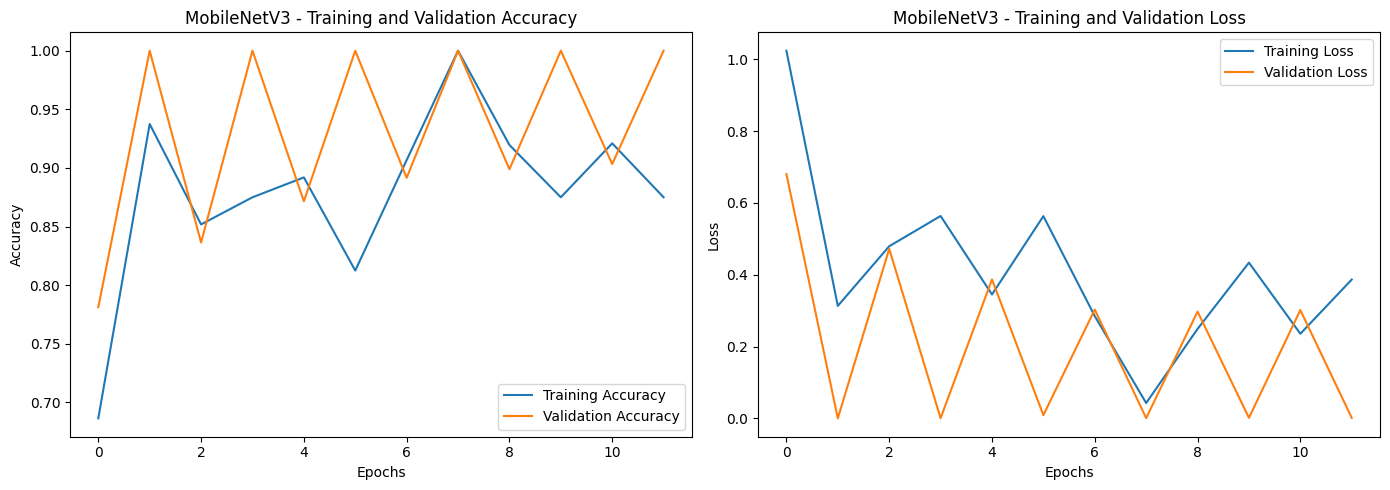

129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step
Prediction time: 15.483091354370117 seconds

Model: MobileNetV3
Overall Accuracy: 0.78
Overall Precision: 0.79
Overall Recall: 0.78
Overall F1-Score: 0.77

Classification Report:
                   precision    recall  f1-score   support

              Car       0.70      1.00      0.82       240
              Bus       0.00      0.00      0.00        23
          Bicycle       0.49      0.56      0.52       122
       Ambassador       0.89      0.77      0.82       240
              Van       0.75      0.19      0.30        80
Motorized2wheeler       0.94      0.89      0.92       320
         Rickshaw       0.66      0.91      0.77       240
         Motorvan       0.75      0.72      0.73       240
            Truck       0.97      0.75      0.84       240
     Autorickshaw       0.50      0.09      0.15        11
             Toto       0.73      0.19      0.30        59
        MiniTruck       0.84      0.98      0.90       240

         

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

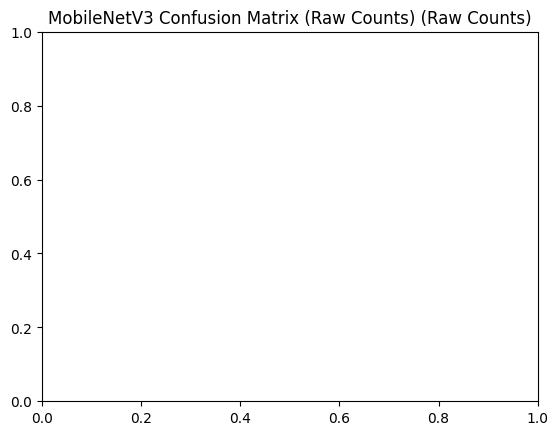

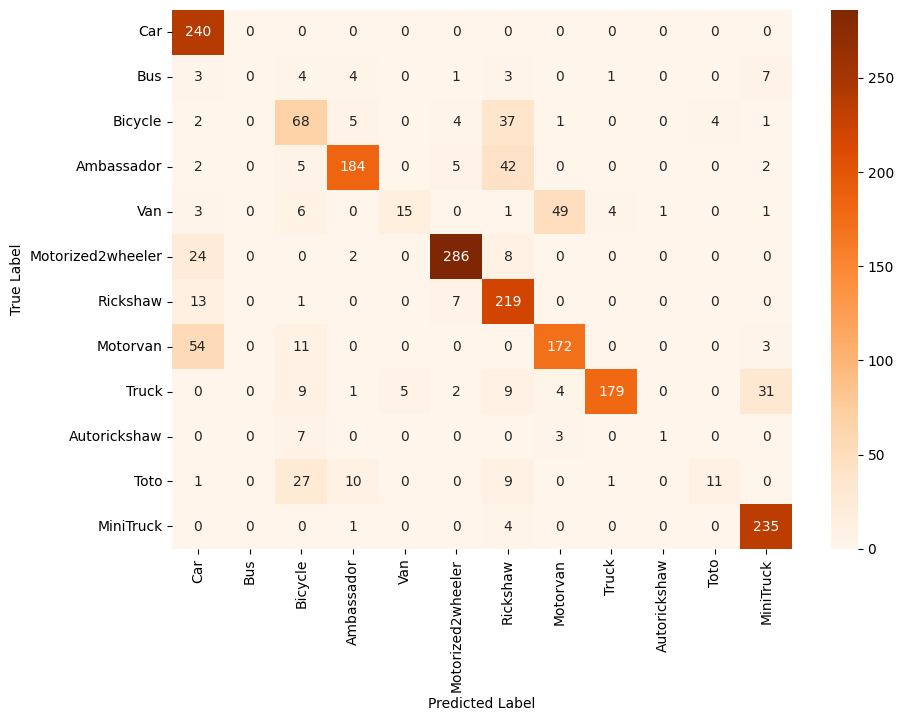

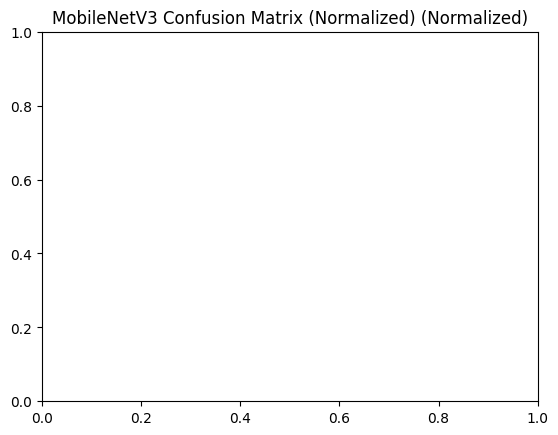

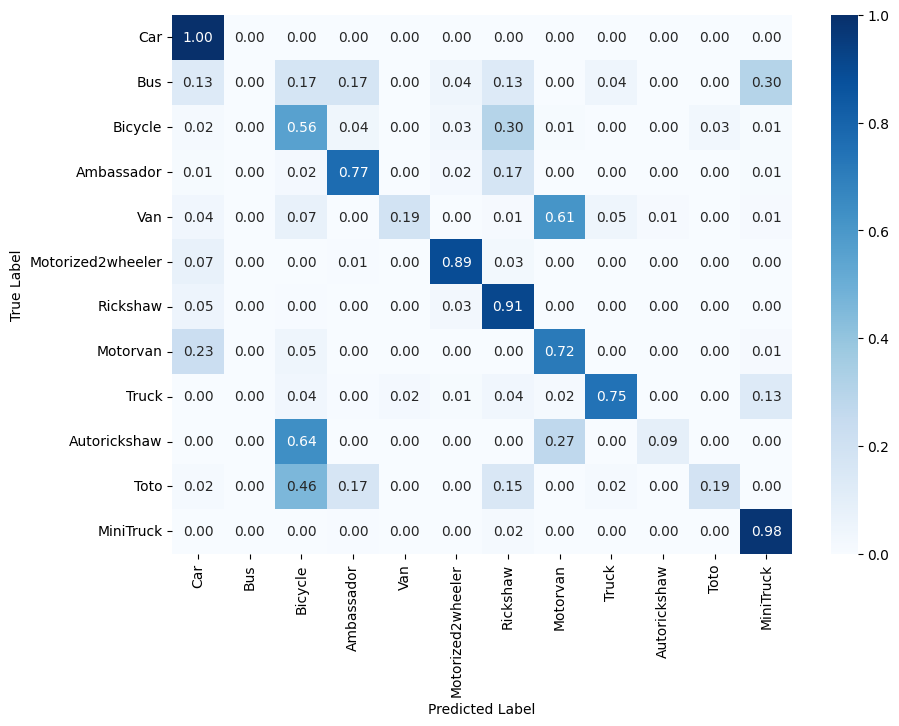

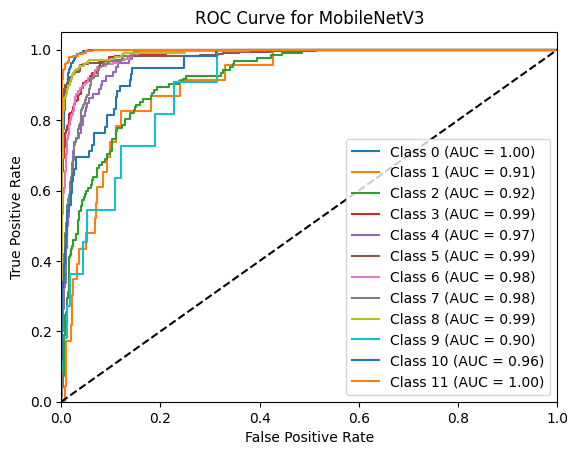

In [9]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Call the train_model function for MobileNetV3
train_model(
    base_model_class=MobileNetV3Large,             # MobileNetV3 Large model
    preprocess_input_function=preprocess_input,    # Preprocessing function for MobileNetV3
    model_name='MobileNetV3',                      # Name for the model
    class_names=class_names                        # Class names defined at the start
)


Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/272 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.0781 - loss: 3.0073   

I0000 00:00:1733070957.027847     125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_1', 4 bytes spill stores, 4 bytes spill loads



272/272 ━━━━━━━━━━━━━━━━━━━━ 104s 240ms/step - accuracy: 0.5575 - loss: 1.4814 - val_accuracy: 0.8452 - val_loss: 0.5194 - learning_rate: 1.0000e-04
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.9375 - loss: 0.2281

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9375 - loss: 0.2281 - val_accuracy: 1.0000 - val_loss: 3.5081e-06 - learning_rate: 1.0000e-04
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 46s 165ms/step - accuracy: 0.8369 - loss: 0.5250 - val_accuracy: 0.8701 - val_loss: 0.4325 - learning_rate: 1.0000e-04
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - accuracy: 0.9375 - loss: 0.1704 - val_accuracy: 1.0000 - val_loss: 3.7636e-06 - learning_rate: 1.0000e-04
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 46s 166ms/step - accuracy: 0.8830 - loss: 0.3576 - val_accuracy: 0.8867 - val_loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 109us/step - accuracy: 0.8750 - loss: 0.4442 - val_accuracy: 1.0000 - val_loss: 5.0696e-04 - learning_rate: 1.0000e-04
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 46s 166ms/step - accuracy: 0.9113 - loss: 0.2810 - val_accuracy: 0.8926 - val_loss: 0.4172 - learning_rate: 1.0000e-04
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 113us/

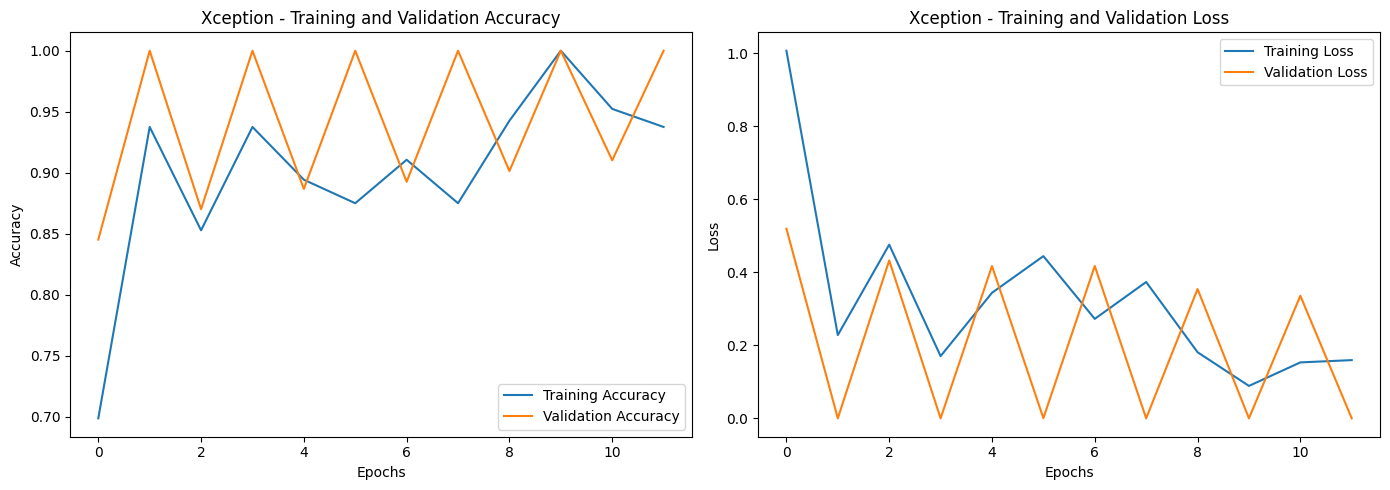

129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step
Prediction time: 13.859996557235718 seconds

Model: Xception
Overall Accuracy: 0.85
Overall Precision: 0.86
Overall Recall: 0.85
Overall F1-Score: 0.83

Classification Report:
                   precision    recall  f1-score   support

              Car       0.81      1.00      0.89       240
              Bus       0.50      0.04      0.08        23
          Bicycle       0.87      0.34      0.49       122
       Ambassador       0.92      0.83      0.87       240
              Van       0.95      0.25      0.40        80
Motorized2wheeler       0.99      0.87      0.92       320
         Rickshaw       0.80      0.91      0.85       240
         Motorvan       0.84      0.99      0.91       240
            Truck       0.85      0.93      0.89       240
     Autorickshaw       0.00      0.00      0.00        11
             Toto       0.46      0.80      0.58        59
        MiniTruck       0.87      0.97      0.92       240

         acc

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

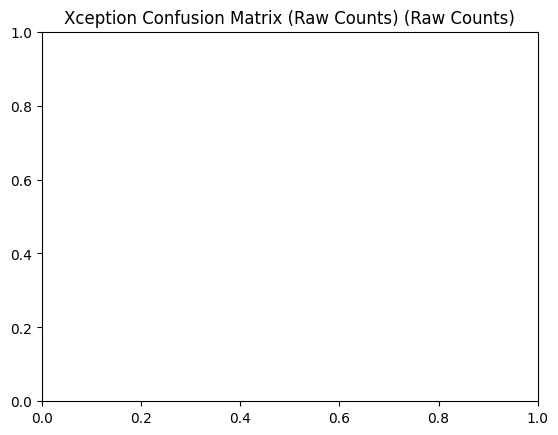

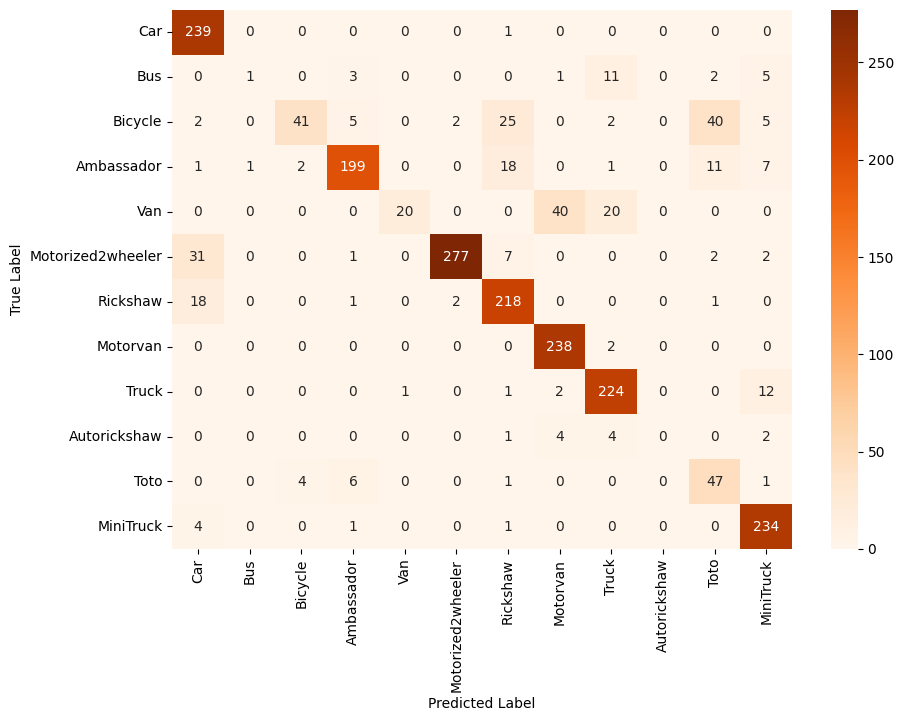

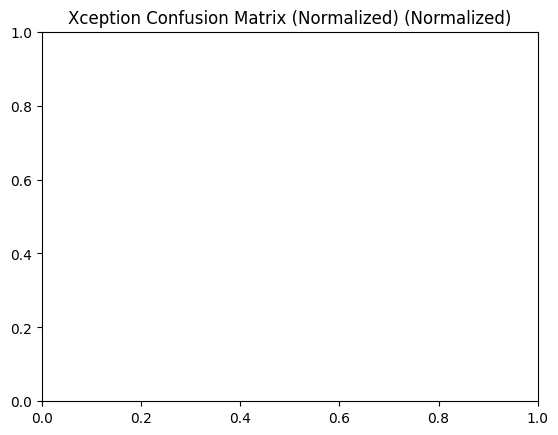

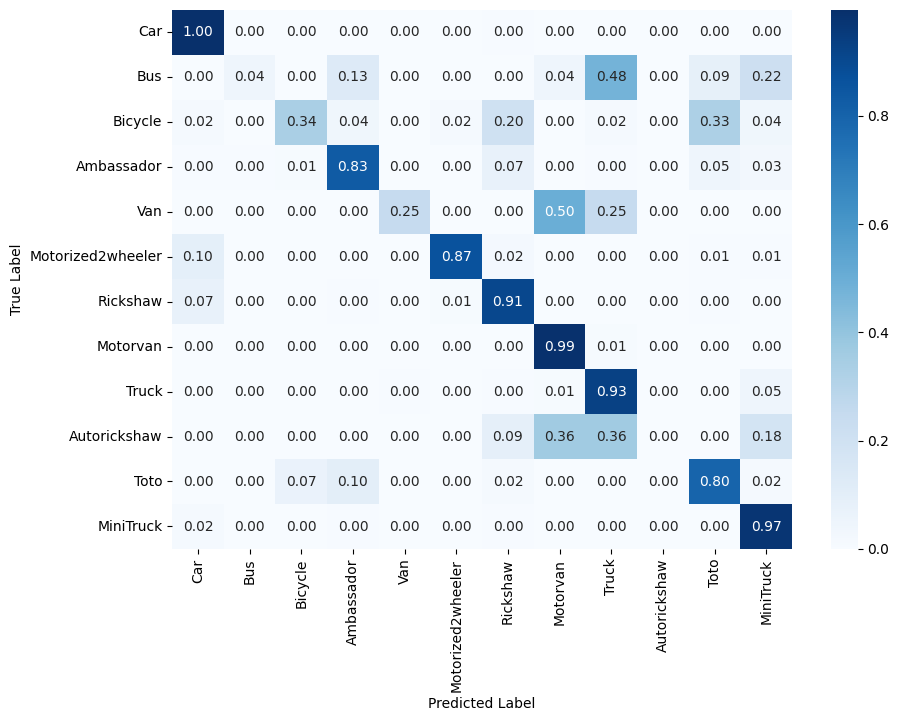

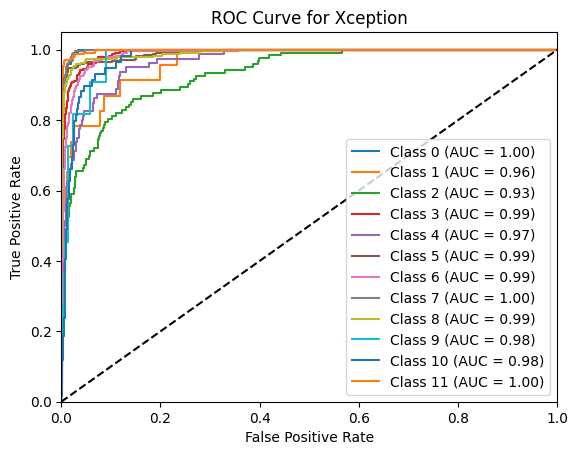

In [10]:
train_model(Xception, tf.keras.applications.xception.preprocess_input, 'Xception', class_names)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 201s 581ms/step - accuracy: 0.7797 - loss: 0.7586 - val_accuracy: 0.9316 - val_loss: 0.1967
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 1.0000 - loss: 0.1118 - val_accuracy: 1.0000 - val_loss: 1.1402e-04
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 144s 491ms/step - accuracy: 0.9662 - loss: 0.1238 - val_accuracy: 0.9536 - val_loss: 0.1540
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9375 - loss: 0.1410 - val_accuracy: 1.0000 - val_loss: 6.4369e-05
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 187s 481ms/step - accuracy: 0.9748 - loss: 0.0797 - val_accuracy: 0.9150 - val_loss: 0.3266
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 260us/step - accuracy: 0.9375 - loss: 0.2221 - val_accuracy: 1.0000 - val_loss: 0.0158
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 139s 501ms/step - accuracy: 0.9790 - loss: 0.0734 - val_accuracy: 0.9331 - val_loss: 0.3230
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step - accuracy: 1.0000 -

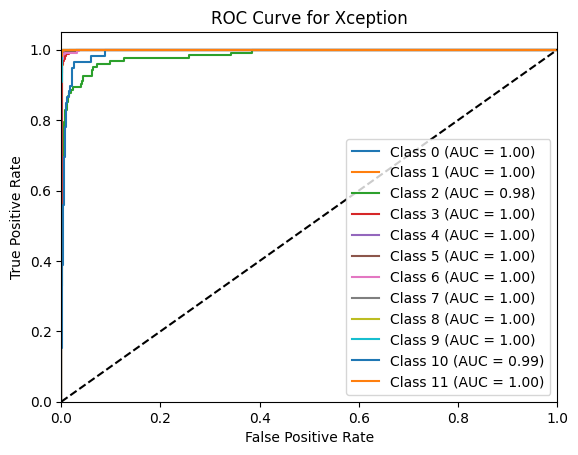

In [18]:
# Train each model separately
train_model(Xception, tf.keras.applications.xception.preprocess_input, 'Xception')

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728821246.018926     114 service.cc:145] XLA service 0x7cb7c01d4d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728821246.018980     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728821326.922285     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


174/272 ━━━━━━━━━━━━━━━━━━━━ 49s 502ms/step - accuracy: 0.7390 - loss: 0.9125

I0000 00:00:1728821488.179951     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_75', 96 bytes spill stores, 96 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 224 bytes spill stores, 224 bytes spill loads



272/272 ━━━━━━━━━━━━━━━━━━━━ 437s 939ms/step - accuracy: 0.7799 - loss: 0.7657 - val_accuracy: 0.9380 - val_loss: 0.2242
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 1:50 409ms/step - accuracy: 0.8750 - loss: 0.5941

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.8750 - loss: 0.5941 - val_accuracy: 1.0000 - val_loss: 5.0408e-06
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 139s 497ms/step - accuracy: 0.9503 - loss: 0.1651 - val_accuracy: 0.9038 - val_loss: 0.3772
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.9375 - loss: 0.0900 - val_accuracy: 1.0000 - val_loss: 1.4424e-05
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 137s 491ms/step - accuracy: 0.9512 - loss: 0.1579 - val_accuracy: 0.9033 - val_loss: 0.4125
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8750 - loss: 0.3025 - val_accuracy: 1.0000 - val_loss: 8.5149e-08
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 137s 492ms/step - accuracy: 0.9586 - loss: 0.1319 - val_accuracy: 0.9092 - val_loss: 0.3373
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 137s 491ms/step - accuracy: 0.9754 - loss: 

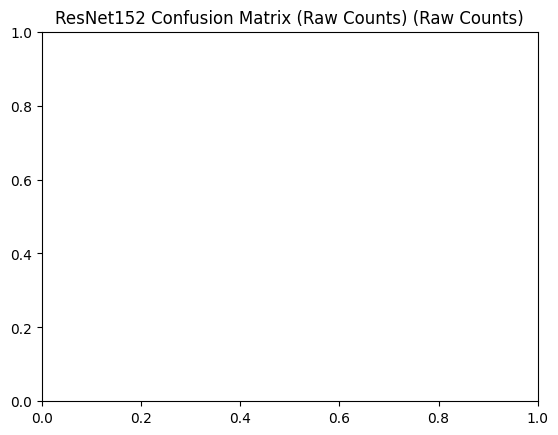

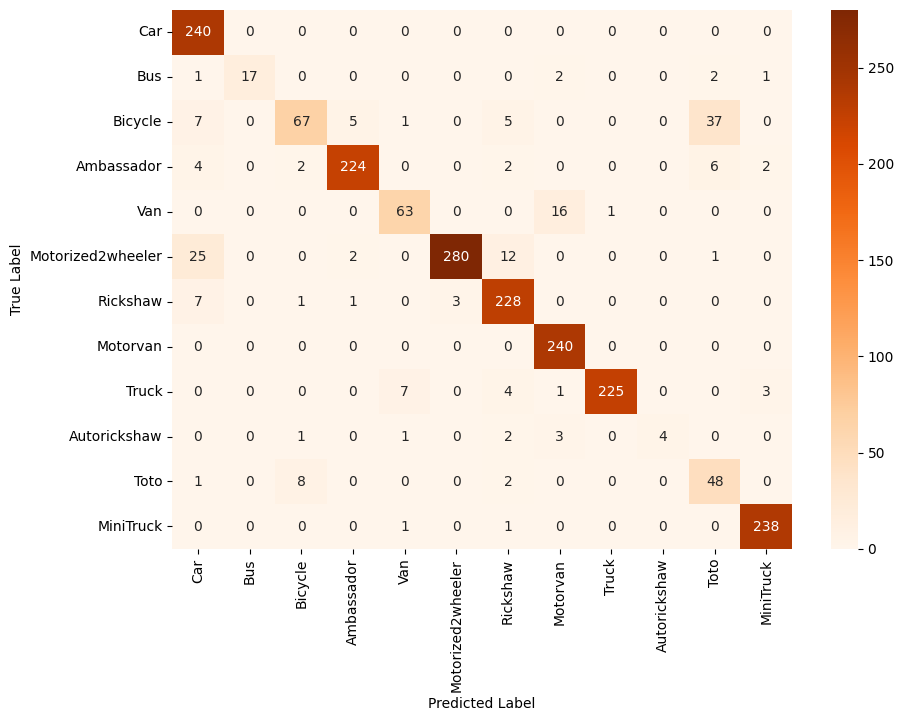

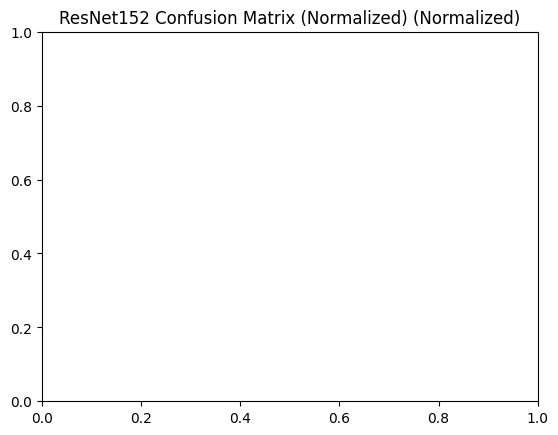

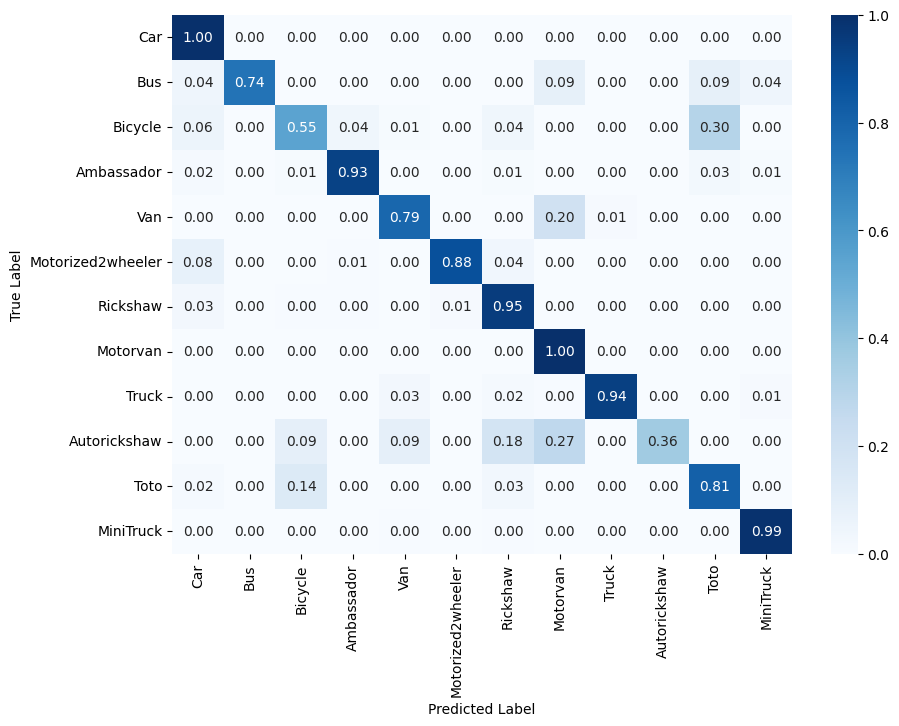

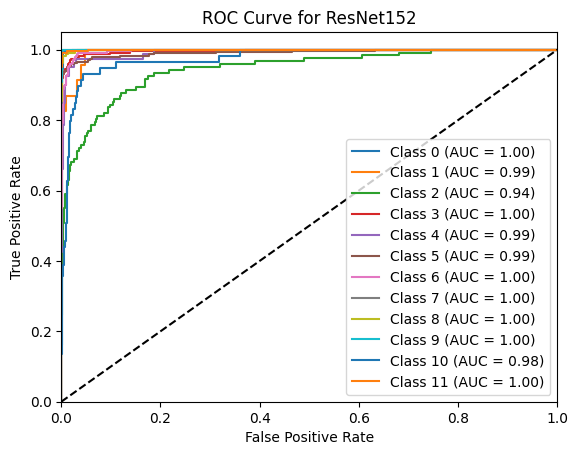

In [4]:
train_model(ResNet152, tf.keras.applications.resnet.preprocess_input, 'ResNet152',class_names)

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
Epoch 1/50


I0000 00:00:1728118733.481404     106 service.cc:145] XLA service 0x7d4c60006b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728118733.481467     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728118817.180457     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 32/272 ━━━━━━━━━━━━━━━━━━━━ 1:41 423ms/step - accuracy: 0.5211 - loss: 1.6477

I0000 00:00:1728118907.283953     106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_75', 96 bytes spill stores, 96 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_78', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 224 bytes spill stores, 224 bytes spill loads



272/272 ━━━━━━━━━━━━━━━━━━━━ 427s 875ms/step - accuracy: 0.7715 - loss: 0.7483 - val_accuracy: 0.8286 - val_loss: 0.5746
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.9375 - loss: 0.1367 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 124s 444ms/step - accuracy: 0.9338 - loss: 0.2001 - val_accuracy: 0.9209 - val_loss: 0.3662
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8750 - loss: 0.1943 - val_accuracy: 1.0000 - val_loss: 7.2888e-05
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 123s 443ms/step - accuracy: 0.9714 - loss: 0.1061 - val_accuracy: 0.9302 - val_loss: 0.2545
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 2.4159e-04
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 124s 444ms/step - accuracy: 0.9773 - loss: 0.0949 - val_accuracy: 0.9312 - val_loss: 0.2557
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 1.0000 - loss: 0.02

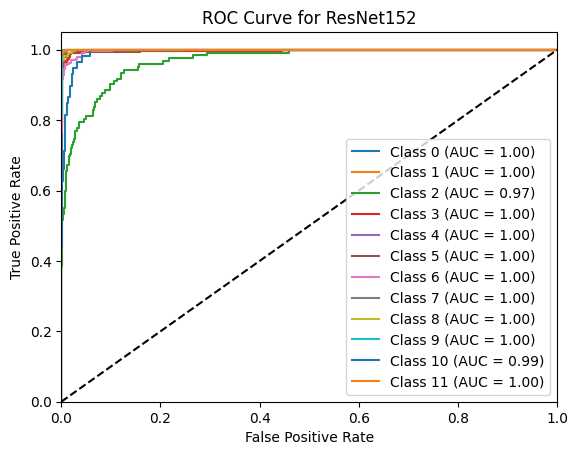

In [15]:
train_model(ResNet152, tf.keras.applications.resnet.preprocess_input, 'ResNet152')

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.


/tmp/ipykernel_30/3173010972.py:65: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 212s 580ms/step - accuracy: 0.6914 - loss: 1.0206 - val_accuracy: 0.8496 - val_loss: 0.4603
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - accuracy: 1.0000 - loss: 0.0535

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 1.0000 - loss: 0.0535 - val_accuracy: 1.0000 - val_loss: 0.0458
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 126s 452ms/step - accuracy: 0.9088 - loss: 0.2987 - val_accuracy: 0.8726 - val_loss: 0.4127
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9375 - loss: 0.2464 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 127s 455ms/step - accuracy: 0.9362 - loss: 0.2055 - val_accuracy: 0.8970 - val_loss: 0.3483
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 1.0000 - loss: 0.1402 - val_accuracy: 1.0000 - val_loss: 1.3128e-04
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 126s 452ms/step - accuracy: 0.9575 - loss: 0.1392 - val_accuracy: 0.9248 - val_loss: 0.2667
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 1.0000 - loss: 0.0514 - val_accuracy: 1.0000 - val_loss: 3.9156e-04
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 125s 450ms/step - accuracy: 0.9644 - loss: 0.1236

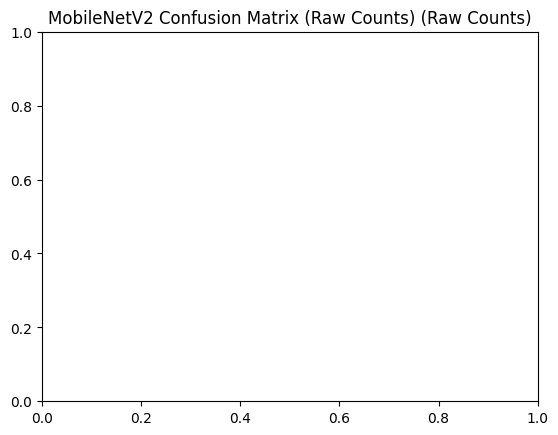

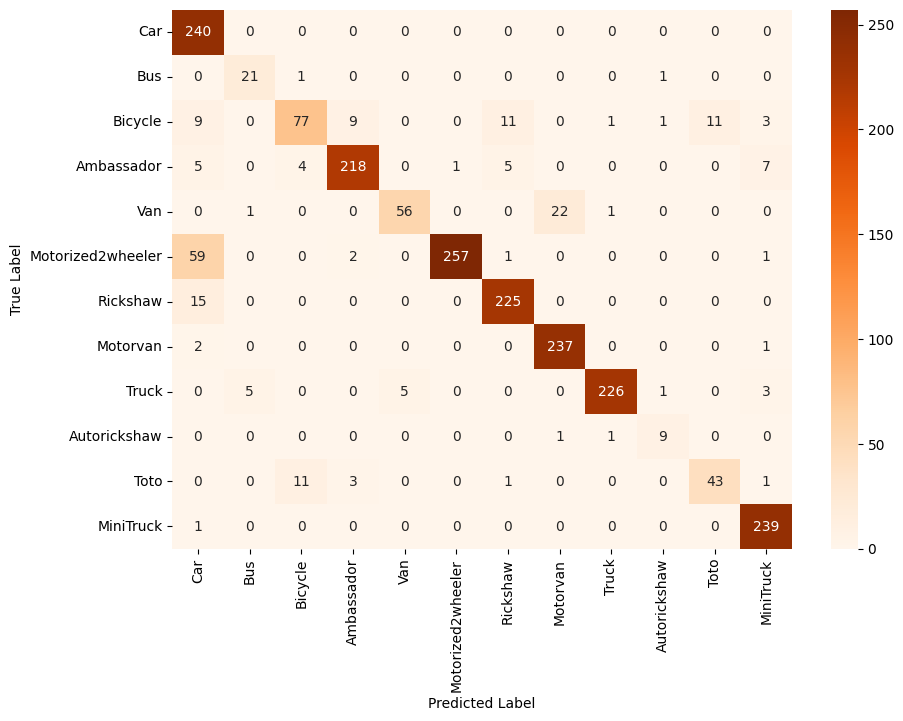

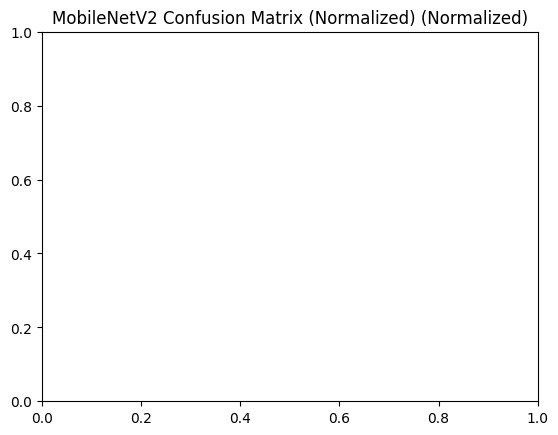

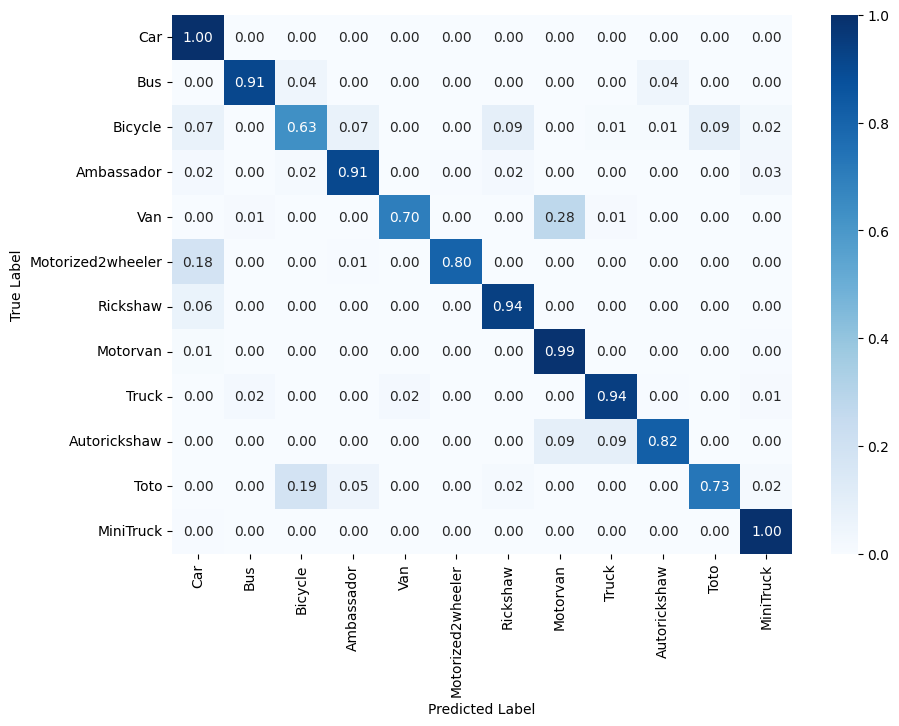

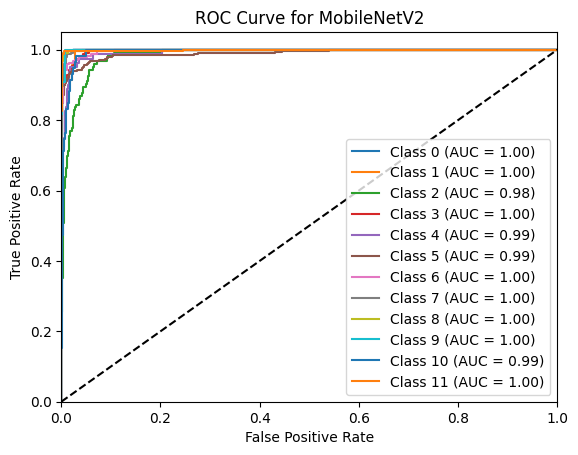

In [6]:
train_model(MobileNetV2, tf.keras.applications.mobilenet_v2.preprocess_input, 'MobileNetV2',class_names)

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 190s 499ms/step - accuracy: 0.6759 - loss: 1.0716 - val_accuracy: 0.8623 - val_loss: 0.4335
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.7500 - loss: 0.8942 - val_accuracy: 1.0000 - val_loss: 0.0173
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 108s 389ms/step - accuracy: 0.9141 - loss: 0.3008 - val_accuracy: 0.8853 - val_loss: 0.3909
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9375 - loss: 0.1646 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 120s 430ms/step - accuracy: 0.9392 - loss: 0.2096 - val_accuracy: 0.8926 - val_loss: 0.3424
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9375 - loss: 0.1284 - val_accuracy: 1.0000 - val_loss: 6.8848e-05
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 109s 390ms/step - accuracy: 0.9526 - 

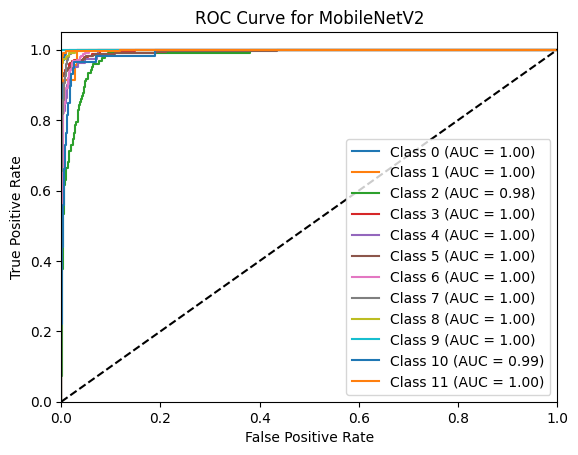

In [19]:
train_model(MobileNetV2, tf.keras.applications.mobilenet_v2.preprocess_input, 'MobileNetV2')

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728825976.752634     112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads



  9/272 ━━━━━━━━━━━━━━━━━━━━ 1:35 364ms/step - accuracy: 0.1896 - loss: 2.7267

I0000 00:00:1728826084.794697     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_15', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_16', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_17', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_27', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_28', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_39', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fus

272/272 ━━━━━━━━━━━━━━━━━━━━ 416s 931ms/step - accuracy: 0.7192 - loss: 0.9183 - val_accuracy: 0.9248 - val_loss: 0.2314
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 51s 191ms/step - accuracy: 0.8125 - loss: 0.5116

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.8125 - loss: 0.5116 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 151s 542ms/step - accuracy: 0.9459 - loss: 0.2171 - val_accuracy: 0.9146 - val_loss: 0.2545
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 1.0000 - loss: 0.1003 - val_accuracy: 1.0000 - val_loss: 7.3327e-04
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 131s 469ms/step - accuracy: 0.9610 - loss: 0.1573 - val_accuracy: 0.8833 - val_loss: 0.3954
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - accuracy: 0.9375 - loss: 0.2971 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 141s 466ms/step - accuracy: 0.9654 - loss: 0.1492 - val_accuracy: 0.9316 - val_loss: 0.2249
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - accuracy: 1.0000 - loss: 0.0512 - val_accuracy: 1.0000 - val_loss: 0.0086
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 130s 466ms/step - accuracy: 0.9786 - loss: 0.0896 - 

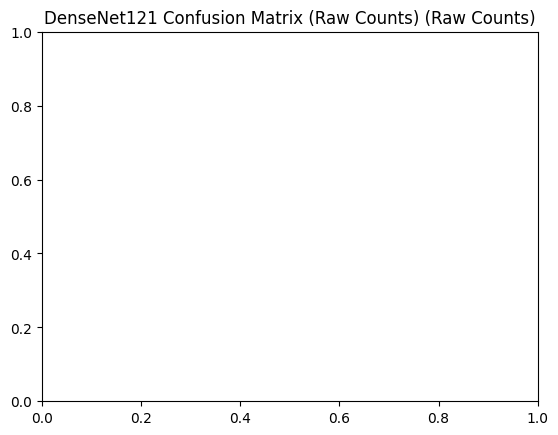

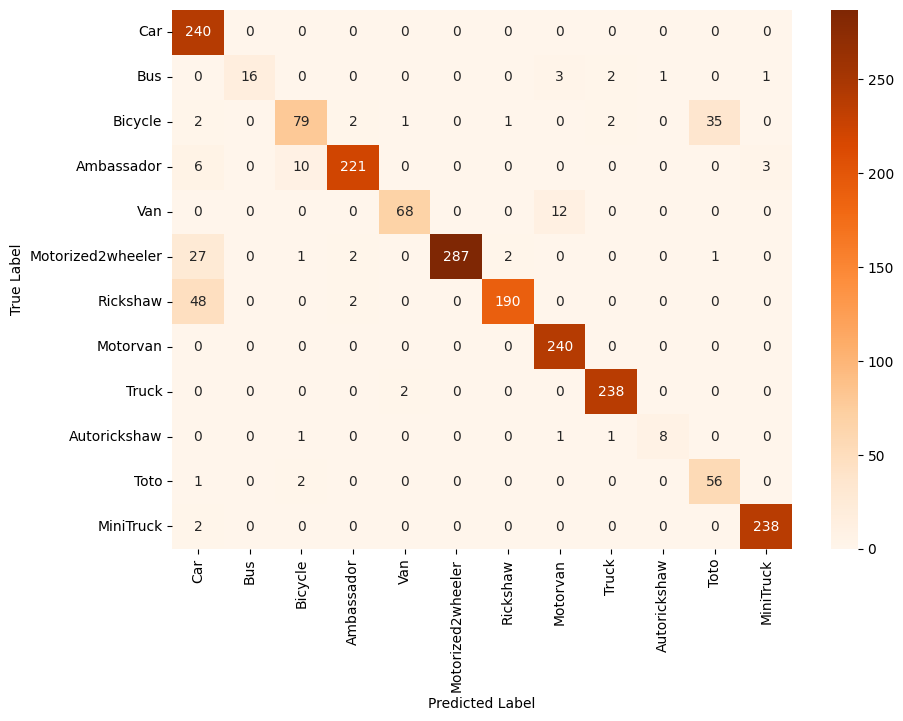

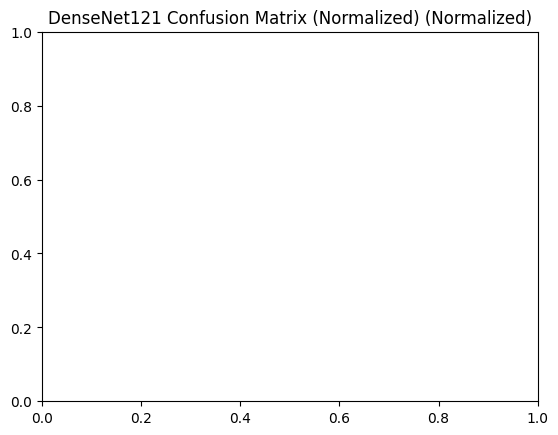

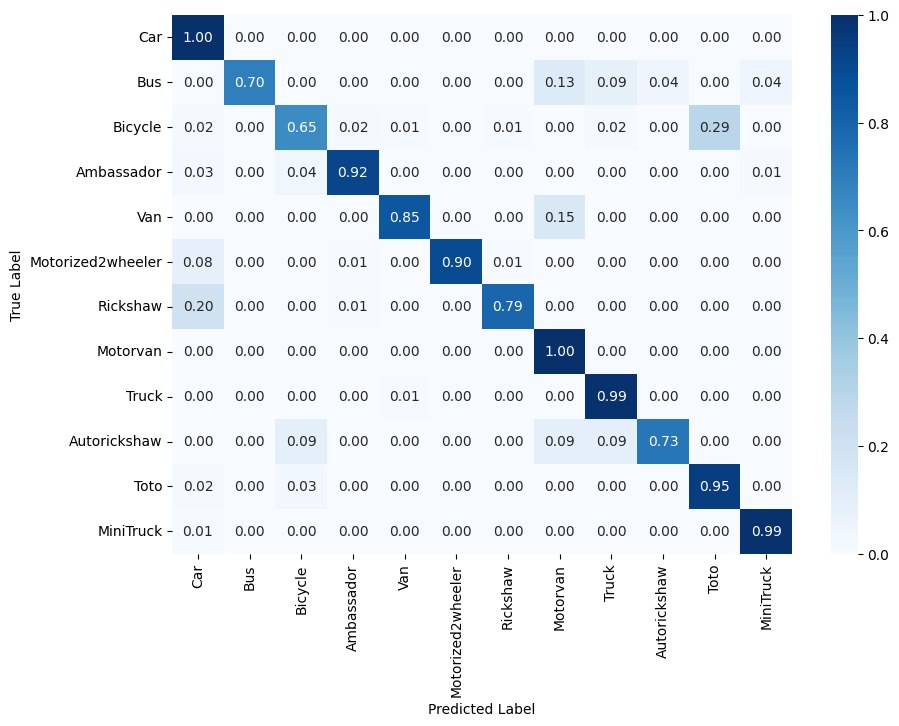

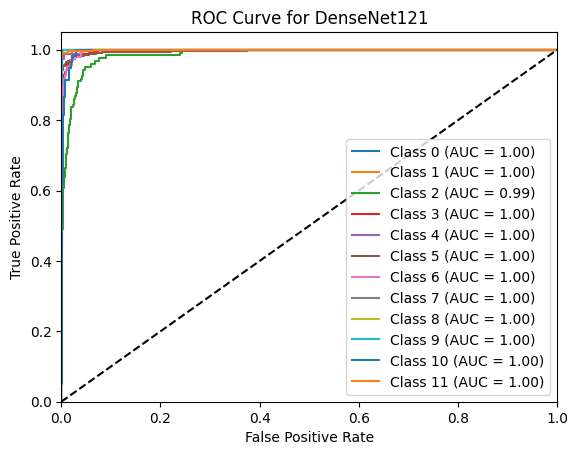

In [7]:
train_model(DenseNet121, tf.keras.applications.densenet.preprocess_input, 'DenseNet121',class_names)

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1728122904.227261     107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_1', 4 bytes spill stores, 4 bytes spill loads



195/272 ━━━━━━━━━━━━━━━━━━━━ 28s 365ms/step - accuracy: 0.6762 - loss: 1.1181

I0000 00:00:1728123083.621401     109 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_15', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_16', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_17', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_27', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_28', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_39', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fus

272/272 ━━━━━━━━━━━━━━━━━━━━ 404s 875ms/step - accuracy: 0.7199 - loss: 0.9661 - val_accuracy: 0.9146 - val_loss: 0.2587
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 1.0000 - loss: 0.1314 - val_accuracy: 1.0000 - val_loss: 4.2492e-04
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 112s 402ms/step - accuracy: 0.9322 - loss: 0.2173 - val_accuracy: 0.9453 - val_loss: 0.1759
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step - accuracy: 0.8750 - loss: 0.2852 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 111s 399ms/step - accuracy: 0.9609 - loss: 0.1469 - val_accuracy: 0.9360 - val_loss: 0.2503
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 1.0000 - loss: 0.0769 - val_accuracy: 1.0000 - val_loss: 8.8121e-04
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 111s 397ms/step - accuracy: 0.9754 - loss: 0.1066 - val_accuracy: 0.9180 - val_loss: 0.3161
129/129 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step

Model: DenseNet121
Overall Accuracy: 0.9

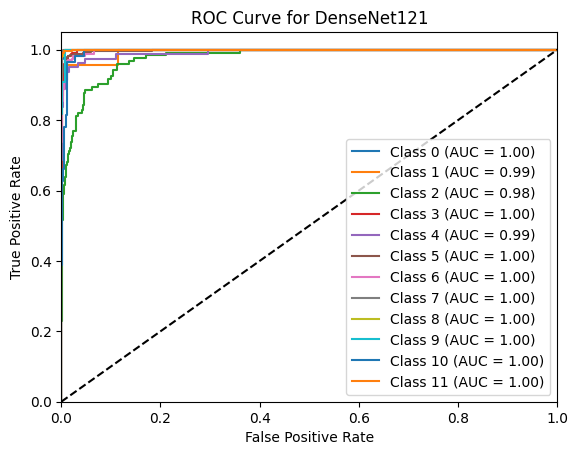

In [20]:
train_model(DenseNet121, tf.keras.applications.densenet.preprocess_input, 'DenseNet121')

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 267s 688ms/step - accuracy: 0.7007 - loss: 1.0251 - val_accuracy: 0.8965 - val_loss: 0.3308
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 45s 166ms/step - accuracy: 0.9375 - loss: 0.1719

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.9375 - loss: 0.1719 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 143s 458ms/step - accuracy: 0.9284 - loss: 0.2358 - val_accuracy: 0.9399 - val_loss: 0.1821
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 1.0000 - loss: 0.0760 - val_accuracy: 1.0000 - val_loss: 1.4464e-04
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 127s 456ms/step - accuracy: 0.9505 - loss: 0.1621 - val_accuracy: 0.9272 - val_loss: 0.2274
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step - accuracy: 1.0000 - loss: 0.0838 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 128s 459ms/step - accuracy: 0.9604 - loss: 0.1309 - val_accuracy: 0.9575 - val_loss: 0.1453
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - accuracy: 0.9375 - loss: 0.3195 - val_accuracy: 1.0000 - val_loss: 9.8802e-04
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 127s 457ms/step - accuracy: 0.9805 - loss: 0.078

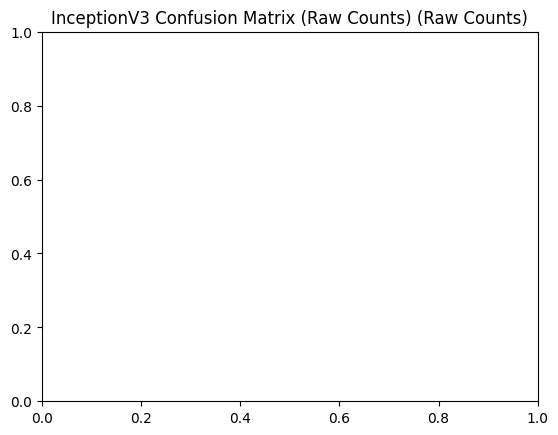

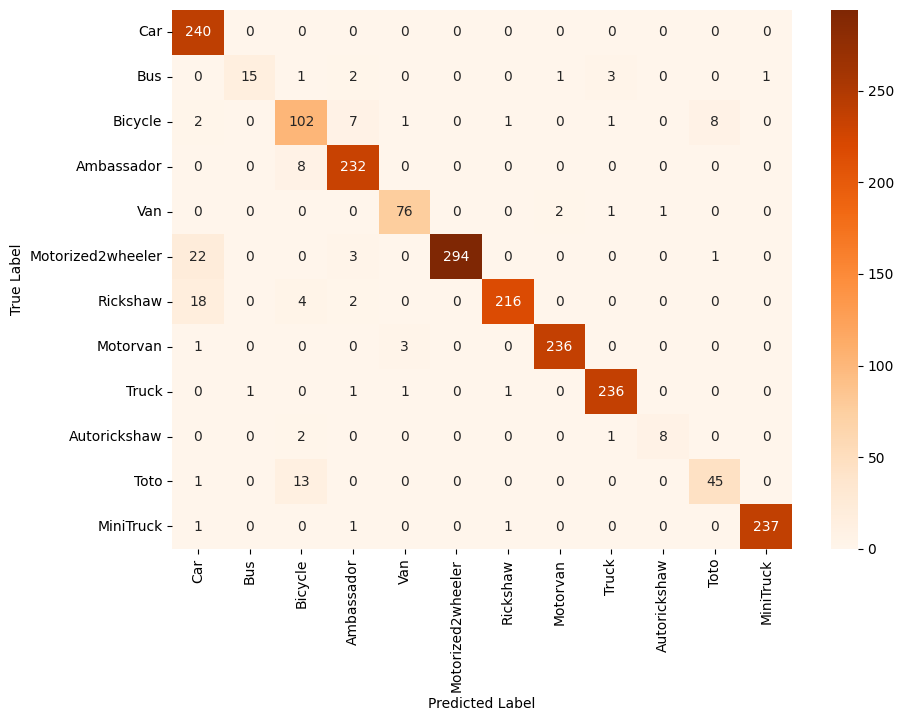

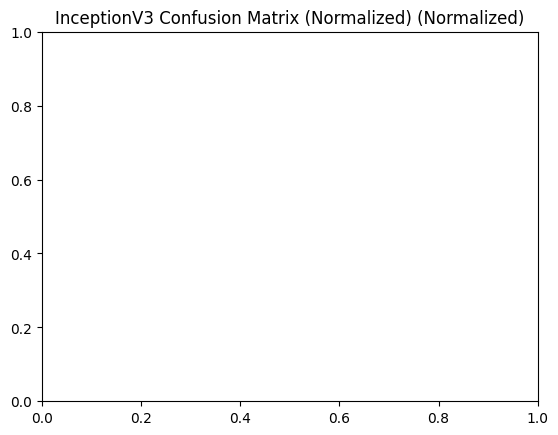

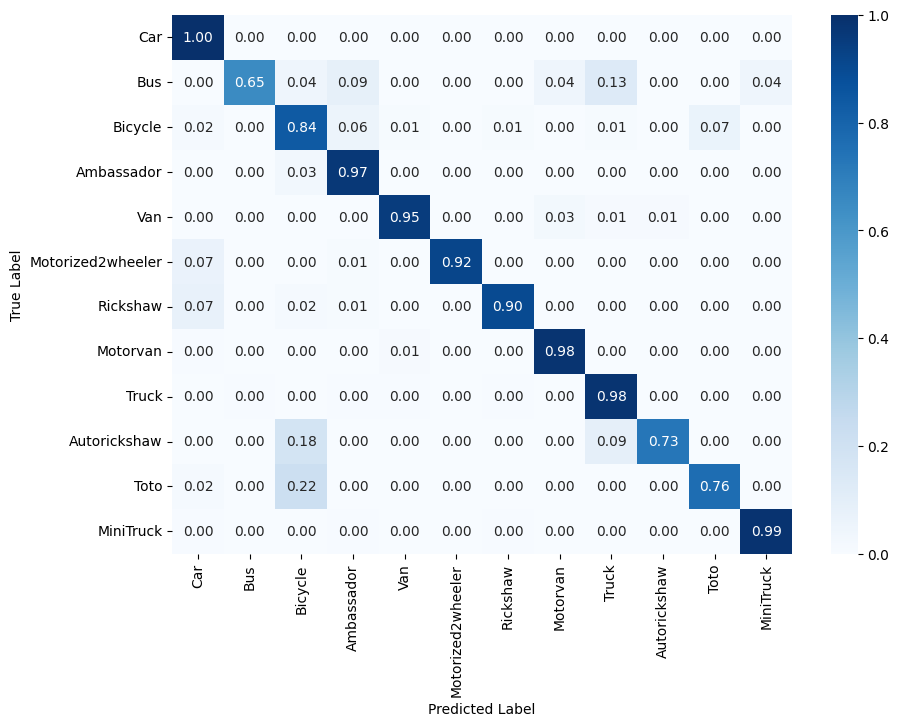

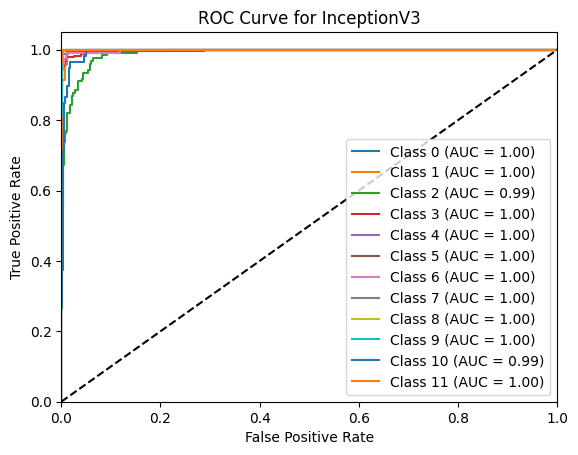

In [8]:
train_model(InceptionV3, tf.keras.applications.inception_v3.preprocess_input, 'InceptionV3',class_names)

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 245s 611ms/step - accuracy: 0.7076 - loss: 1.0014 - val_accuracy: 0.9004 - val_loss: 0.2948
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.9375 - loss: 0.1842 - val_accuracy: 1.0000 - val_loss: 2.9037e-04
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 109s 392ms/step - accuracy: 0.9358 - loss: 0.2381 - val_accuracy: 0.9199 - val_loss: 0.2451
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - accuracy: 1.0000 - loss: 0.0717 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 142s 392ms/step - accuracy: 0.9551 - loss: 0.1581 - val_accuracy: 0.9385 - val_loss: 0.1937
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - accuracy: 1.0000 - loss: 0.0784 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 109s 391ms/step - accuracy: 0.973

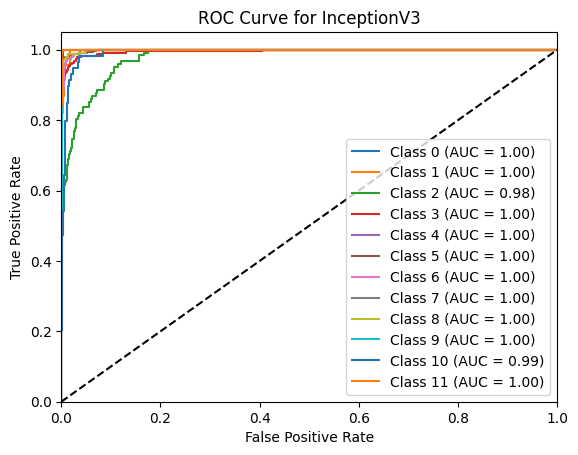

In [21]:
train_model(InceptionV3, tf.keras.applications.inception_v3.preprocess_input, 'InceptionV3')

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 172s 349ms/step - accuracy: 0.5504 - loss: 1.4766 - val_accuracy: 0.8521 - val_loss: 0.4558
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8125 - loss: 0.3824

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8125 - loss: 0.3824 - val_accuracy: 1.0000 - val_loss: 0.0105
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 47s 168ms/step - accuracy: 0.8591 - loss: 0.4527 - val_accuracy: 0.8682 - val_loss: 0.4075
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9375 - loss: 0.3105 - val_accuracy: 1.0000 - val_loss: 7.9543e-04
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 47s 170ms/step - accuracy: 0.8880 - loss: 0.3420 - val_accuracy: 0.8706 - val_loss: 0.4033
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 117us/step - accuracy: 1.0000 - loss: 0.1127 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 47s 170ms/step - accuracy: 0.9214 - loss: 0.2511 - val_accuracy: 0.8838 - val_loss: 0.3727
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 119us/step - accuracy: 0.8125 - loss: 0.4123 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 48s 172ms/step - accuracy: 0.9236 - loss: 0.2350 - val_ac

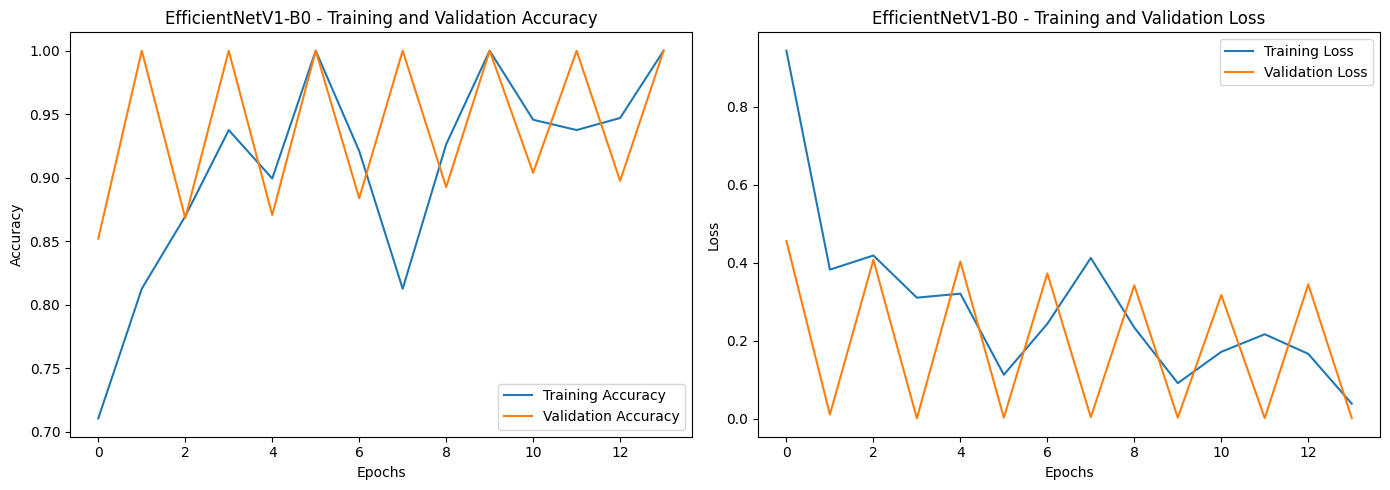

129/129 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step
Prediction time: 18.500926733016968 seconds

Model: EfficientNetV1-B0
Overall Accuracy: 0.87
Overall Precision: 0.88
Overall Recall: 0.87
Overall F1-Score: 0.86

Classification Report:
                   precision    recall  f1-score   support

              Car       0.85      0.99      0.91       240
              Bus       1.00      0.17      0.30        23
          Bicycle       0.71      0.30      0.43       122
       Ambassador       0.83      0.91      0.87       240
              Van       0.69      0.85      0.76        80
Motorized2wheeler       1.00      0.87      0.93       320
         Rickshaw       0.87      0.94      0.90       240
         Motorvan       0.95      0.96      0.96       240
            Truck       0.88      0.86      0.87       240
     Autorickshaw       0.50      0.27      0.35        11
             Toto       0.45      0.76      0.57        59
        MiniTruck       0.97      0.97      0.97       240

  

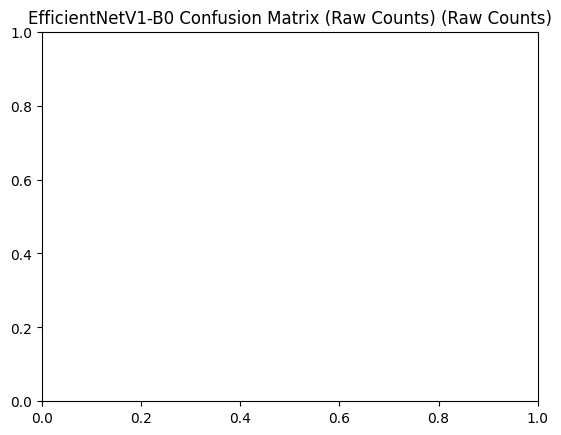

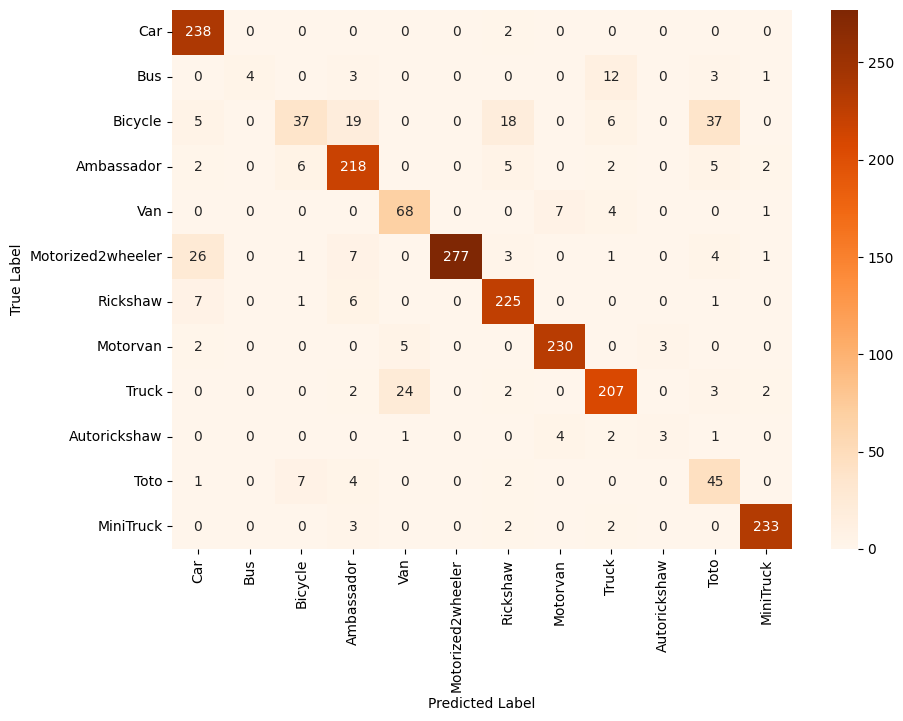

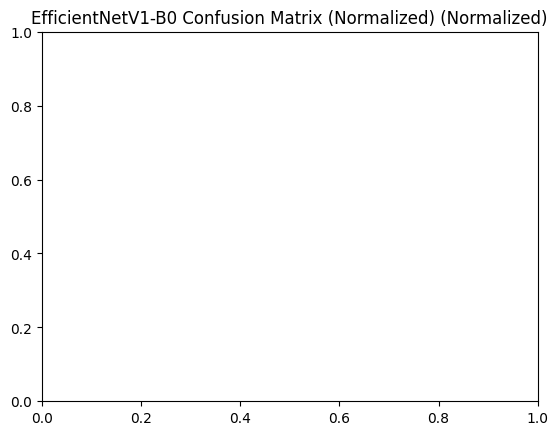

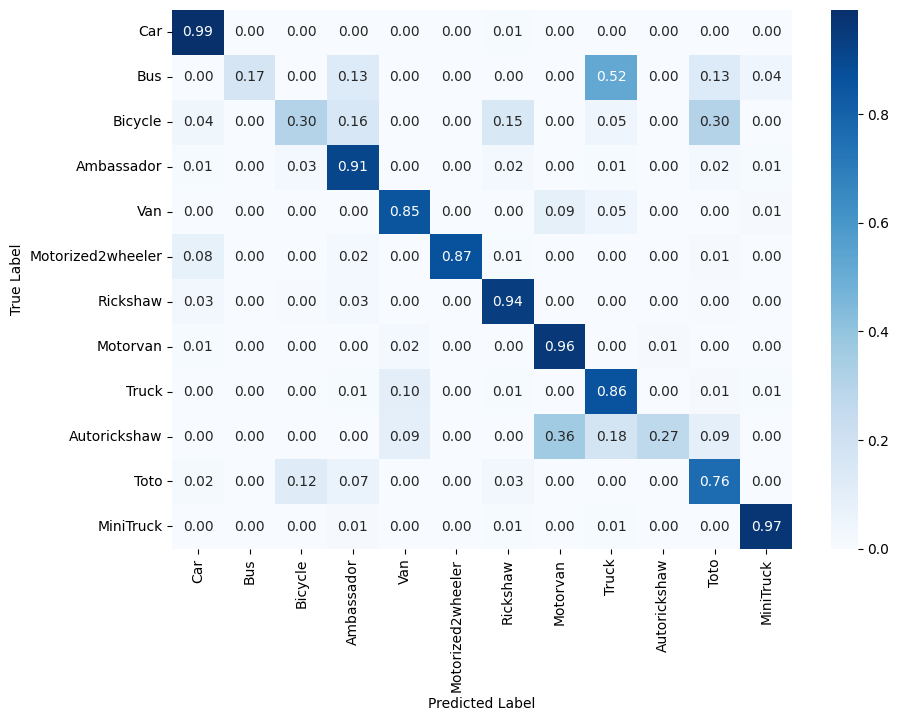

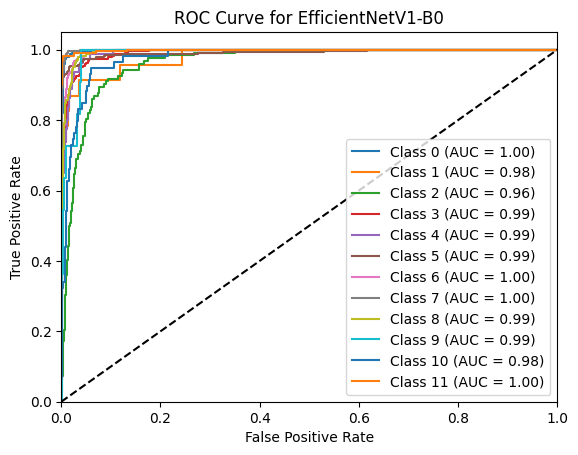

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

train_model(EfficientNetB0, preprocess_input, 'EfficientNetV1-B0', class_names)

Found 4357 images belonging to 12 classes.
Found 2055 images belonging to 12 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


272/272 ━━━━━━━━━━━━━━━━━━━━ 206s 399ms/step - accuracy: 0.5261 - loss: 1.5493 - val_accuracy: 0.8521 - val_loss: 0.4452
Epoch 2/50
  1/272 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 1.0000 - loss: 0.1084

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 1.0000 - loss: 0.1084 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 48s 174ms/step - accuracy: 0.8700 - loss: 0.4312 - val_accuracy: 0.8740 - val_loss: 0.3757
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8750 - loss: 0.2350 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 47s 170ms/step - accuracy: 0.9044 - loss: 0.3147 - val_accuracy: 0.8896 - val_loss: 0.3387
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8750 - loss: 0.2638 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 49s 176ms/step - accuracy: 0.9231 - loss: 0.2504 - val_accuracy: 0.9019 - val_loss: 0.2960
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 1.0000 - loss: 0.0862 - val_accuracy: 1.0000 - val_loss: 9.7212e-04
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 47s 169ms/step - accuracy: 0.9242 - loss: 0.2171 - val_accura

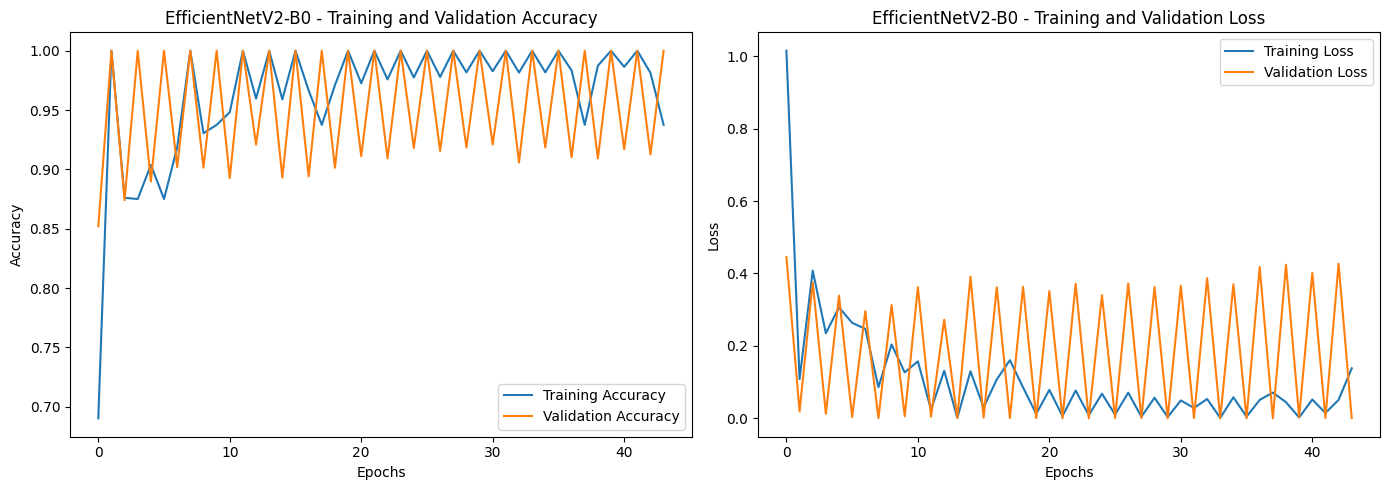

129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step
Prediction time: 19.016345977783203 seconds

Model: EfficientNetV2-B0
Overall Accuracy: 0.91
Overall Precision: 0.93
Overall Recall: 0.91
Overall F1-Score: 0.91

Classification Report:
                   precision    recall  f1-score   support

              Car       0.81      1.00      0.90       240
              Bus       1.00      0.48      0.65        23
          Bicycle       0.87      0.39      0.54       122
       Ambassador       0.95      0.90      0.92       240
              Van       0.84      0.97      0.90        80
Motorized2wheeler       1.00      0.94      0.97       320
         Rickshaw       0.95      0.87      0.90       240
         Motorvan       1.00      0.98      0.99       240
            Truck       0.96      0.95      0.95       240
     Autorickshaw       0.82      0.82      0.82        11
             Toto       0.43      0.92      0.58        59
        MiniTruck       1.00      0.99      0.99       240

  

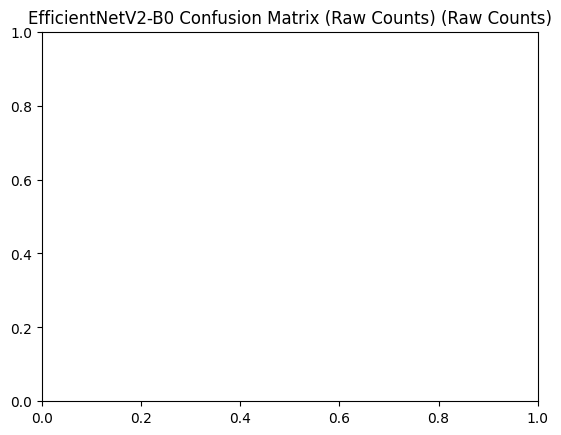

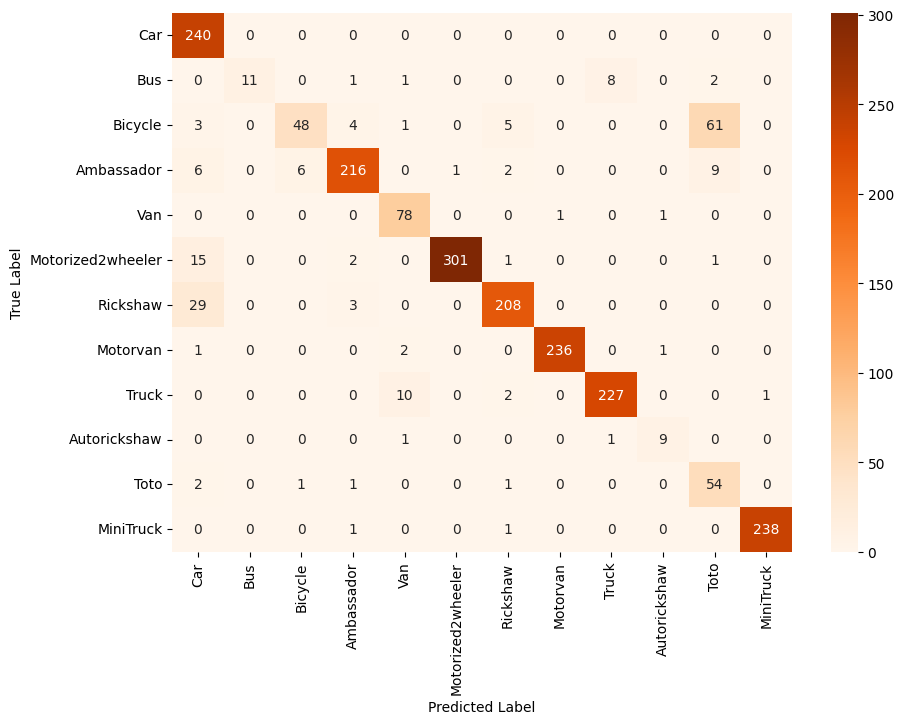

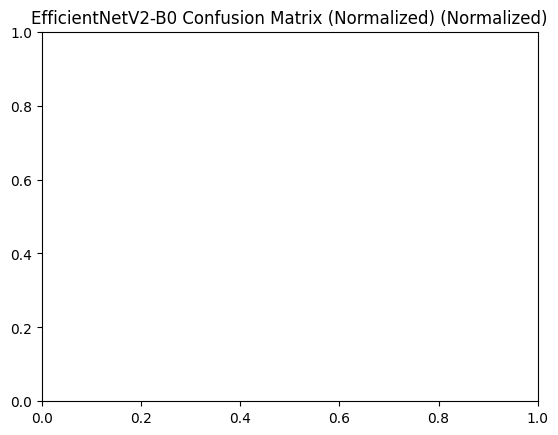

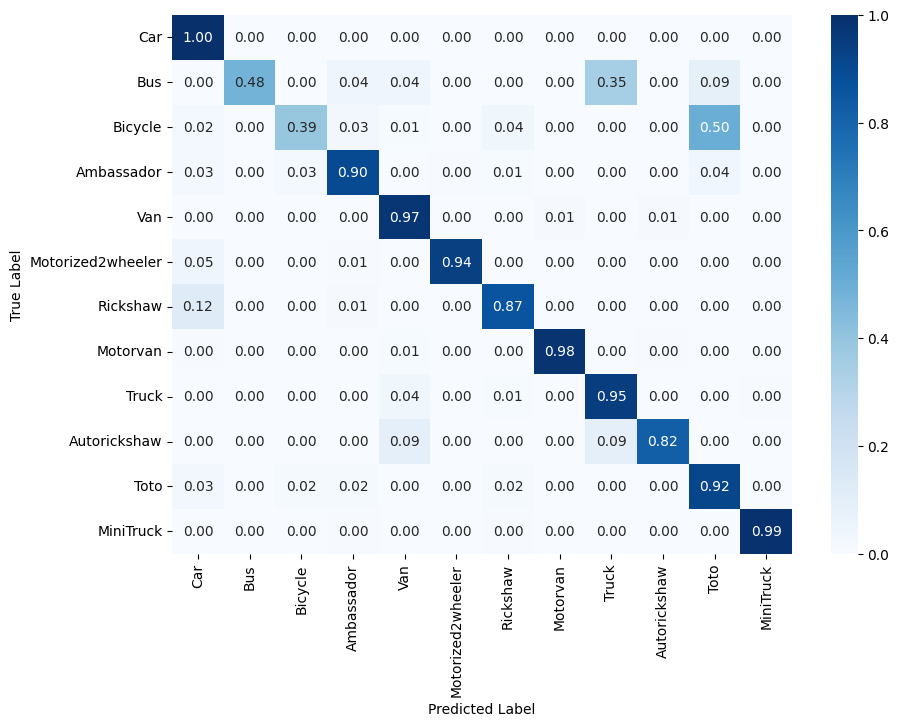

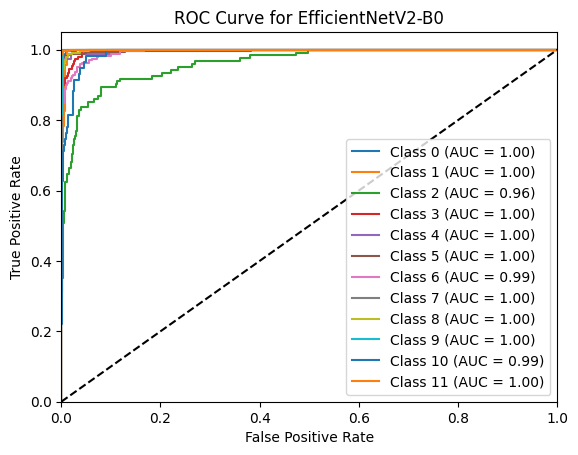

In [14]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

train_model(EfficientNetV2B0, preprocess_input, 'EfficientNetV2-B0', class_names)